In [2]:
# Tail Risk and Black Swan Events: Excess kurtosis is a direct measure of tail risk. 
# It tells us that we can't assume extreme events are as rare as the normal distribution implies. 
# Task: model (daily log) returns by Student-t location/scale using Markov chain Monte Carlo (MCMC).
# MCMC method: w/o a closed-form distribution, only a function proportional to it. RW to stationary distribution.
# Detailed-balance-> target distribution and transitionprobability-> accecptance probability
# mean of returns: Gaussian random walk (Symmetric → proposal ratio cancels)
# scale (volatility): log-random-walk (asymmetric) <- because volatility must be positive
# degrees of freedom: log-random-walk (asymmetric)
# assume likelihood and propose prior-> get prosterior using Metropolis–Hastings (MH). 
# Then sameple future returns from it: posterior predictive distribution.
# Derive VaR and ES.

In [4]:
# -----------------------------------------------
# Data bridge & settings (OFFLINE)
# -----------------------------------------------
import numpy as np

rng = np.random.default_rng(123)
returns = rng.standard_t(df=6, size=1500) * 0.015  # fat-tailed synthetic
source = "Synthetic example (replace with your real log returns)"

print("Return source  :", source)
print("n observations :", returns.size)
print("sample mean    :", float(returns.mean()))
print("sample stdev   :", float(returns.std(ddof=1)))

# Risk settings
notional_value = 100_000.0
horizon_days   = 1       # simulate 1-day ahead
conf_levels    = [0.95, 0.99]

# MCMC settings
n_iter    = 30000        # total iterations
burn_in   = 5000         # empirical (will explore ESS in the future)
thin      = 5            # keep every 5 draw (reduce autocorrelation)
rng = np.random.default_rng(42)

# Proposal step sizes (tune to get ~20-40% acceptance)
s_mu      = 0.0005       # RW for mu
s_logsig  = 0.10         # RW on log(sigma)
s_lognu   = 0.10         # RW on log(nu-2)


Return source  : Synthetic example (replace with your real log returns)
n observations : 1500
sample mean    : 0.00021503327870107646
sample stdev   : 0.018750422280663766


In [5]:
# -----------------------------------------------
# Model components (log-likelihood, priors, posterior)
# -----------------------------------------------
import math
import numpy as np

# prevents underflow: use log-dist
def student_t_loglik(r, mu, sigma, nu):
    """
    Sum of log pdf of Student-t(loc=mu, scale=sigma, df=nu) for data r (vector).
    Requires sigma>0, nu>2. Vectorized over r.
    """
    if sigma <= 0 or nu <= 2:
        return -np.inf
    z = (r - mu) / sigma
    n = r.size
    c = (math.lgamma((nu+1)/2) - math.lgamma(nu/2)
         - 0.5*(math.log(nu) + math.log(math.pi)) - math.log(sigma))
    # Use log1p for stability
    return n*c - 0.5*(nu+1) * np.sum(np.log1p((z*z)/nu))

def log_prior(mu, sigma, nu):
    """
    Priors:
      mu ~ Normal(0, 1^2)
      sigma ~ Half-Normal(0.05)
      nu-2 ~ Exponential(rate=1/30)
    """
    if sigma <= 0 or nu <= 2:
        return -np.inf
    # mu ~ N(0,1)
    lp_mu = -0.5*(mu**2) - 0.5*math.log(2*math.pi)
    # sigma ~ HalfNormal(0.05)
    s0 = 0.05
    if sigma <= 0:
        lp_sigma = -np.inf
    else:
        # half-normal pdf: sqrt(2)/(s0*sqrt(pi)) * exp(-sigma^2/(2 s0^2))
        lp_sigma = math.log(math.sqrt(2)/(s0*math.sqrt(math.pi))) - (sigma**2)/(2*s0*s0)
    # nu-2 ~ Exp(1/30)
    lam = 1/30.0
    y = nu - 2.0
    if y <= 0:
        lp_nu = -np.inf
    else:
        lp_nu = math.log(lam) - lam*y
    return lp_mu + lp_sigma + lp_nu

def log_posterior(r, mu, sigma, nu):
    lp = log_prior(mu, sigma, nu)
    if not np.isfinite(lp):
        return -np.inf
    ll = student_t_loglik(r, mu, sigma, nu)
    return lp + ll


In [6]:
# -----------------------------------------------
# Metropolis–Hastings sampler
# -----------------------------------------------

def mh_sampler(r, n_iter, s_mu, s_logsig, s_lognu, rng):
    # Initialize at simple estimates
    mu   = float(r.mean())
    sigma= float(r.std(ddof=1))
    nu   = 8.0  # reasonable start (fat tails)
    log_sigma = math.log(max(sigma, 1e-6))
    log_nu2   = math.log(max(nu-2.0, 1e-6))

    current_lp = log_posterior(r, mu, sigma, nu)
    accepts = 0

    chain = np.zeros((n_iter, 3), dtype=float)  # three columns: mu, sigma, nu

    for k in range(n_iter):
        mu_p     = mu + rng.normal(0, s_mu) # jitter!
        logsig_p = log_sigma + rng.normal(0, s_logsig) # jitter!
        sigma_p  = math.exp(logsig_p)
        lognu_p  = log_nu2 + rng.normal(0, s_lognu) # jitter!
        nu_p     = 2.0 + math.exp(lognu_p)

        prop_lp = log_posterior(r, mu_p, sigma_p, nu_p)

        # Hastings correction for log-RW on sigma and on (nu-2):
        # q(sigma | sigma') / q(sigma' | sigma) = sigma'/sigma
        # q(nu-2 | (nu'-2)) / q((nu'-2) | nu-2) = (nu'-2)/(nu-2)
        log_q_ratio = (logsig_p - log_sigma) + (lognu_p - log_nu2)  # = log(sigma'/sigma) + log((nu'-2)/(nu-2))

        log_alpha = (prop_lp - current_lp) + log_q_ratio
        if math.log(rng.uniform()) < min(0.0, log_alpha):
            # accept
            mu, sigma, nu = mu_p, sigma_p, nu_p
            log_sigma, log_nu2 = logsig_p, lognu_p
            current_lp = prop_lp
            accepts += 1
        # if no update, simply copied over
        chain[k, 0] = mu
        chain[k, 1] = sigma
        chain[k, 2] = nu

    acc_rate = accepts / n_iter # to check for efficiency
    return chain, acc_rate

chain, acc_rate = mh_sampler(returns, n_iter, s_mu, s_logsig, s_lognu, rng)
print(f"Acceptance rate: {acc_rate:.3f} (aim for ~0.2–0.4; adjust s_* if needed)") # will improve later


Acceptance rate: 0.198 (aim for ~0.2–0.4; adjust s_* if needed)


Posterior summary (after burn-in & thinning):
mu : {'mean': 0.0003553893108291614, 'median': 0.0003468677215330442, 'sd': 0.00044724632080802386, 'q05': -0.0003714990774102446, 'q95': 0.0011107422105397062}
sig: {'mean': 0.01514545698654619, 'median': 0.015149809525544965, 'sd': 0.00045523289988392586, 'q05': 0.014394765456018355, 'q95': 0.015889079081521387}
nu : {'mean': 6.021061474704347, 'median': 5.925701202493851, 'sd': 0.8354747551100443, 'q05': 4.8474395350433, 'q95': 7.600671837572096}


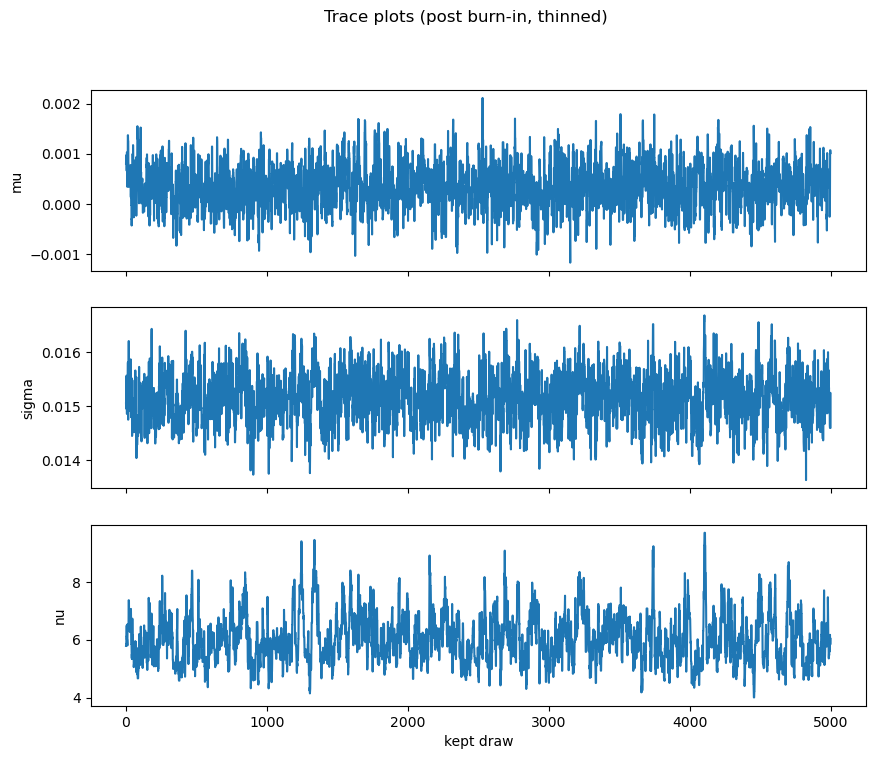

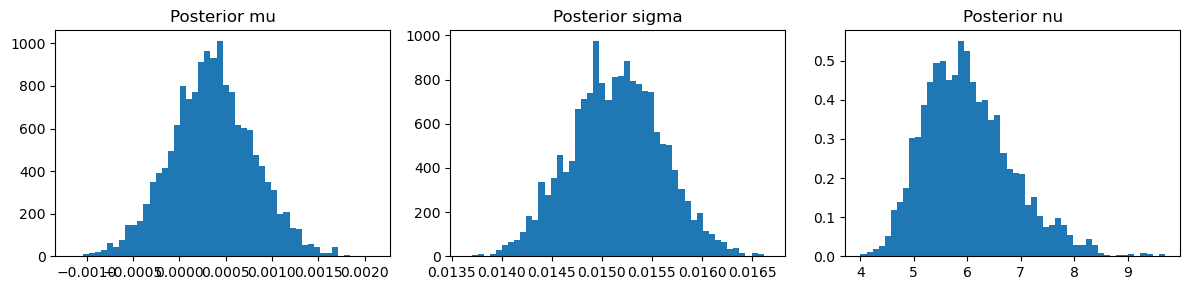

In [7]:
# -----------------------------------------------
# Diagnostics & posterior summaries
# -----------------------------------------------
import matplotlib.pyplot as plt

# Burn-in & thinning
keep = chain[burn_in::thin]
mu_samps, sig_samps, nu_samps = keep[:,0], keep[:,1], keep[:,2]

def summarize(x):
    return {
        "mean": float(np.mean(x)),
        "median": float(np.median(x)),
        "sd": float(np.std(x, ddof=1)),
        "q05": float(np.quantile(x, 0.05)),
        "q95": float(np.quantile(x, 0.95)),
    }

print("Posterior summary (after burn-in & thinning):")
print("mu :", summarize(mu_samps))
print("sig:", summarize(sig_samps))
print("nu :", summarize(nu_samps))

# Simple trace plots (looks like the burn-in is good enough)
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
axs[0].plot(keep[:,0]); axs[0].set_ylabel("mu")
axs[1].plot(keep[:,1]); axs[1].set_ylabel("sigma")
axs[2].plot(keep[:,2]); axs[2].set_ylabel("nu"); axs[2].set_xlabel("kept draw")
fig.suptitle("Trace plots (post burn-in, thinned)")
plt.show()

# Marginal histograms
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].hist(mu_samps, bins=50, density=True);   axs[0].set_title("Posterior mu")
axs[1].hist(sig_samps, bins=50, density=True);  axs[1].set_title("Posterior sigma")
axs[2].hist(nu_samps, bins=50, density=True);   axs[2].set_title("Posterior nu")
plt.tight_layout()
plt.show()


Posterior predictive: 95% VaR = 2886.56, ES = 4070.38
Posterior predictive: 99% VaR = 4820.44, ES = 5855.98


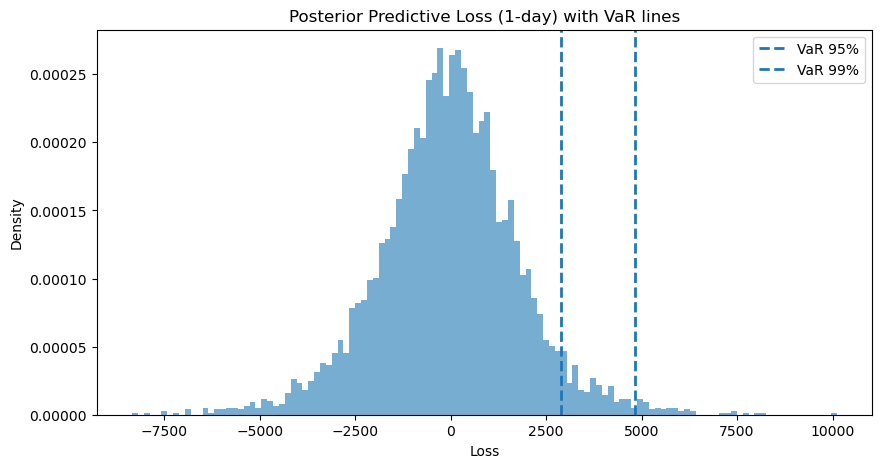

In [8]:
# -----------------------------------------------
# Posterior predictive VaR & ES
# -----------------------------------------------
# Draw one-day-ahead returns from Student-t using posterior samples.
# We'll take one predictive draw per kept posterior draw (many draws total).

def rstudent_t(rng, df, loc, scale, size=None):
    # standard t * scale + loc
    return rng.standard_t(df, size=size) * scale + loc

n_keep = mu_samps.size
pred_r = rstudent_t(rng, df=nu_samps, loc=mu_samps, scale=sig_samps, size=n_keep)

pnl  = notional_value * pred_r
loss = -pnl  # positive is loss; negative means profit

def var_es(losses, alpha):
    v = np.quantile(losses, alpha)
    tail = losses[losses >= v]
    es = float(tail.mean()) if tail.size else np.nan
    return float(v), es

for a in conf_levels:
    VaR, ES = var_es(loss, a)
    print(f"Posterior predictive: {int(a*100)}% VaR = {VaR:.2f}, ES = {ES:.2f}")

# Plot predictive loss with VaR lines
plt.figure(figsize=(10,5))
plt.hist(loss, bins=120, density=True, alpha=0.6)
for a in conf_levels:
    VaR, _ = var_es(loss, a)
    plt.axvline(VaR, linestyle="--", linewidth=2, label=f"VaR {int(a*100)}%")
plt.title("Posterior Predictive Loss (1-day) with VaR lines")
plt.xlabel("Loss"); plt.ylabel("Density"); plt.legend()
plt.show()


In [9]:
# -----------------------------------------------
# (compare): Normal plug-in VaR/ES (context)
# -----------------------------------------------
# Compare to a simple Normal model using sample mean/stdev of returns
mu_hat = float(returns.mean())
sd_hat = float(returns.std(ddof=1))

mu_L    = -notional_value * (mu_hat * horizon_days)      # mean loss
sd_L    =  notional_value * (sd_hat * np.sqrt(horizon_days))  # loss std

from scipy.stats import norm
for a in conf_levels:
    z = norm.ppf(a)
    var_norm = mu_L + sd_L * z
    es_norm  = mu_L + sd_L * norm.pdf(z) / (1-a)
    print(f"[Normal plug-in] {int(a*100)}% VaR = {var_norm:.2f}, ES = {es_norm:.2f}")


[Normal plug-in] 95% VaR = 3062.67, ES = 3846.17
[Normal plug-in] 99% VaR = 4340.50, ES = 4975.89
